### Imports
Utilizaremos PyTorch como framework e pegaremos o MNIST dataset direto dele. Utilizaremos sklearn para mostrarmos a matriz de confusão e mostrar as métricas ao longo do treinamento.

In [ ]:
# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# utilizar cuda para acelerar o treinamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Datasets e Dataloaders
Baixamos os datasets pelo pytorch, dividimos entre dataset de treino, validação e teste. Dividimos o dataset de treino (50 mil imagens) em validação (15% do conjunto) e treino (85% do conjunto), enquanto o conjunto de treino possuí 10 mil imagens.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

In [ ]:
train_ds = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,    # transformar as imagens para tensores e normalizar
    download=True,
)

length = len(train_ds)
len_val = int(0.15 * length)    # tamanho do ds de validação
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])    # dividimos aleatoriamente

test_ds = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True,
)

Aqui definimos os dataloaders, para podermos treinar e atualizar os parametros do nosso modelo a BATCH_SIZES instâncias por vez, utilizando NUM_WORKERS processos em paralelo.

In [ ]:

BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)


In [ ]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Cada instância é do formado (128, 1, 28, 28): 128 imagens de 1 canal (preto e branco), de dimensão 28x28

Visualizando o dataset

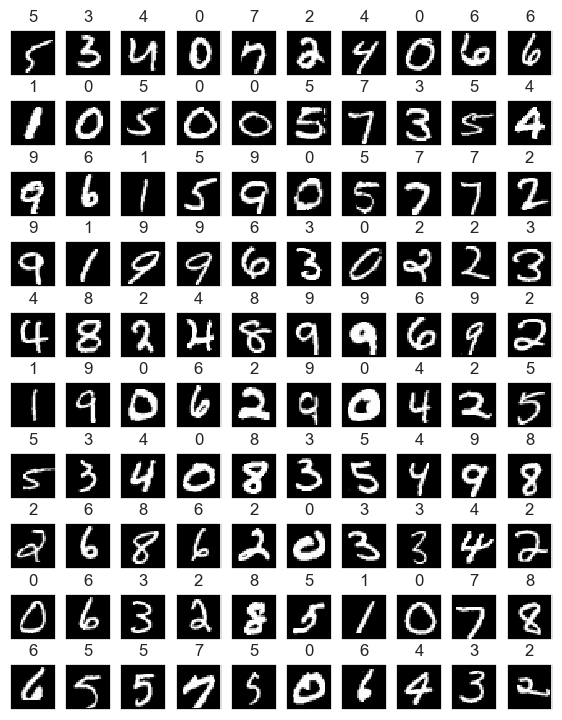

In [ ]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

### Funções/Classes Auxiliares

Classe para registramos a loss a cada época

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Função de treinamento

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

Função de validação

In [ ]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

Função para realizar o treinamento

In [ ]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if epoch == EPOCHS:
      print(f"Train loss: {round(train_loss, 6):<7}")
      print(f"Valid. loss: {round(val_loss, 6):<7}\n")

  # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1

  # plotar o gráfico de loss
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

Função para testar o modelo

In [ ]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(10))
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

Funções de inicialização a serem testadas

In [ ]:
# He normal
def init_weights_he_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# He uniform
def init_weights_he_uniform(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

### Parâmetros e arquitetura inicial

Nessa classe podemos definir uma arquitetura personalizada, botando quantas camadas convolucionais/fully conected quisermos, cada uma personalizada da maneira que quisermos testar, evitando que precisemos definir várias classes diferentes para cada arquitetura que quisermos testar.

In [ ]:
class CNN(nn.Module):
  def __init__(self, architecture, in_channels=1):
    super().__init__()
    self.layers = nn.ModuleList()

    # itera pelas camadas convolucionais
    for layer in architecture['conv']:
      conv_layer = nn.Conv2d(
        in_channels,
        layer['out_channels'],
        kernel_size=layer['kernel_size'],
        stride=layer['stride'],
        padding=layer['padding']
      )
      self.layers.append(conv_layer)

      # caso tenha, aplica normalização de batch, função de ativação e pooling
      if 'batch_norm' in layer and layer['batch_norm']:
        self.layers.append(nn.BatchNorm2d(layer['out_channels']))
      if 'activation' in layer:
        self.layers.append(layer['activation']())
      if 'pooling' in layer:
        pool_layer = getattr(nn, layer['pooling']['type'])(**layer['pooling']['params'])
        self.layers.append(pool_layer)
      in_channels = layer['out_channels']

    # Fully Connected Layers
    self.flatten = nn.Flatten()
    mlp_input_size = architecture['mlp_input_size']
    self.fc_layers = nn.ModuleList()
    for units in architecture['mlp']:
      self.fc_layers.append(nn.Linear(mlp_input_size, units['out_units']))
      if 'activation' in units:
        self.fc_layers.append(units['activation']())
      if 'dropout' in units:
        self.fc_layers.append(nn.Dropout(units['dropout']))
      mlp_input_size = units['out_units']

    # output layer
    self.output_layer = nn.Linear(mlp_input_size, architecture['output_units'])

  def forward(self, x):
    # aplica a parte convolucional
    for layer in self.layers:
      x = layer(x)

    # aplica a parte fully connected
    x = self.flatten(x)
    for layer in self.fc_layers:
      x = layer(x)

    # camada de output
    x = self.output_layer(x)
    return x

Função para testar combinações de hiperparâmetros

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def hyperparameter_search(train_dl, val_dl, param_grid, device):
    best_params = None
    best_accuracy = 0

    for params in ParameterGrid(param_grid):
        print(f"Testing with parameters: {params}")

        model = CNN(params['architecture']).to(device)
        # aplica inicialização, caso seja passada
        if 'initialization' in params:
            if params['initialization'] == 'normal':
                model.apply(init_weights_he_normal)
            else:
                model.apply(init_weights_he_uniform)

        # hiperparametros como otimizador, learning rate e número de épocas são passados como entrada
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
        loss_fn = nn.CrossEntropyLoss()

        train(model, train_dl, val_dl, loss_fn, optimizer, device, params['epochs'])
        val_accuracy = test(model, val_dl, device)

        # salvar quais foram os parâmetros que deram melhor acurácia
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    return best_params, best_accuracy

### Teste inicial: achando o otimizador, learning rate e quantidade de épocas

Arquitetura inicial: 1 camada convolucional com 8 filtros/canais de saída de tamanho 3x3, stride=1, padding=1, função de ativação ReLU, 1 camada de max pooling com kernel 2x2 e stride 2, sem batch normalization e 2 fully connected layer, uma com 128 unidades, outra com 64 unidades, ambas utilizando ReLU e dropout com 30% de chance, com uma camada de saída com 10 unidades.

Testaremos várias combinações de: learning rate (0.001, 0.01 e 0.1), otimizador (sgd e adam) e épocas (15, 30 e 45).

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'SGD'}
Train loss: 0.575705
Valid. loss: 0.39772

              precision    recall  f1-score   support

           0     0.9255    0.9754    0.9498       853
           1     0.9070    0.9606    0.9330      1015
           2     0.8916    0.8740    0.8827       913
           3     0.8647    0.8843    0.8744       925
           4     0.9084    0.8857    0.8969       884
           5     0.8858    0.7797    0.8294       826
    

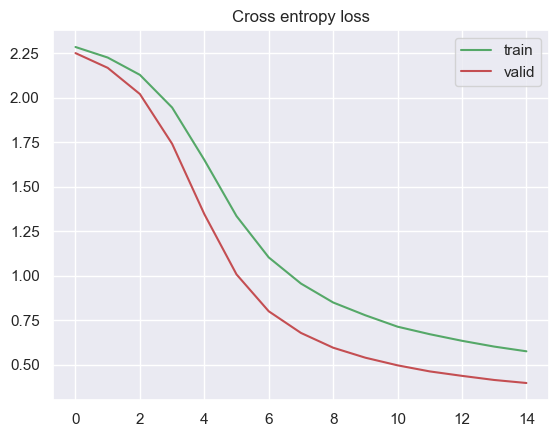

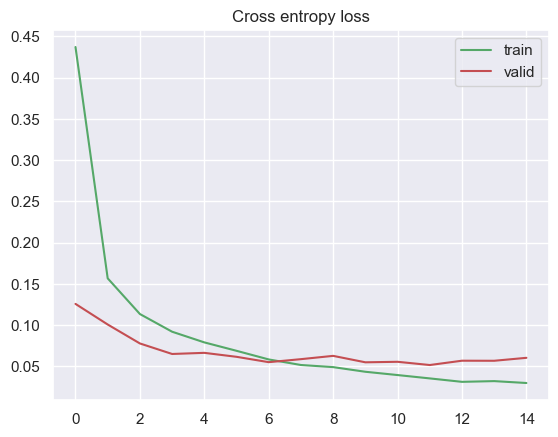

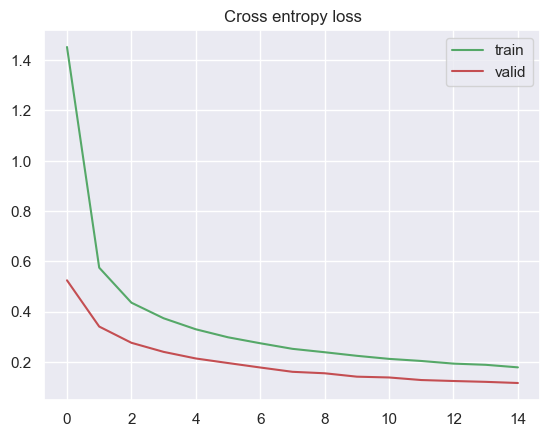

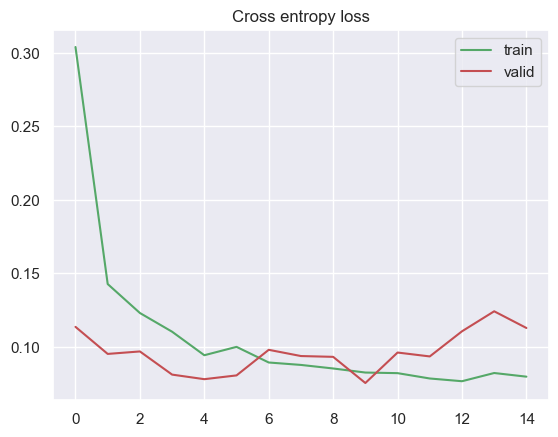

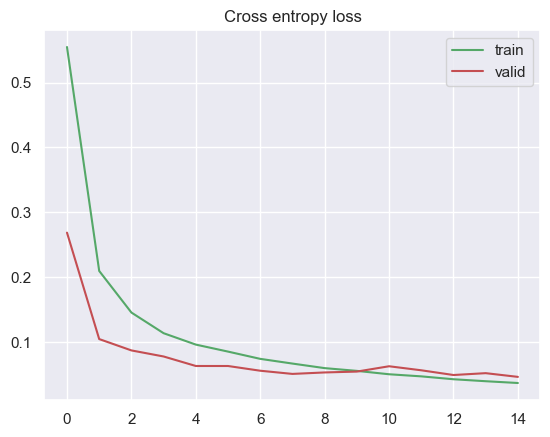

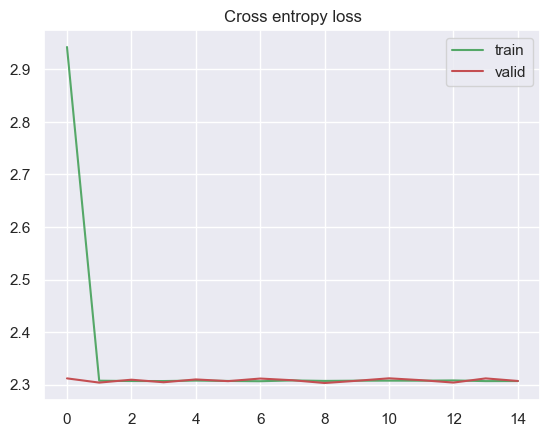

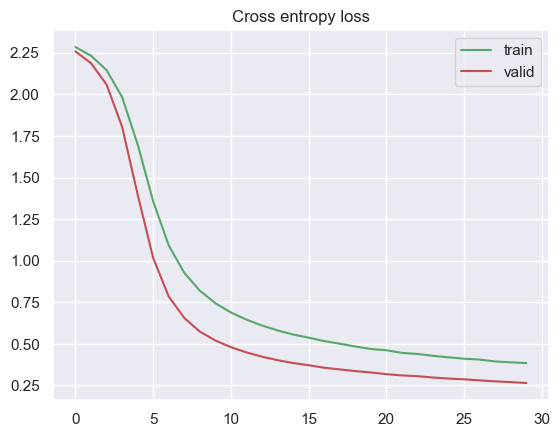

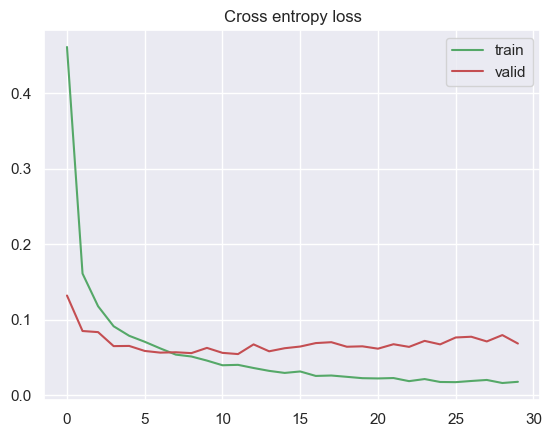

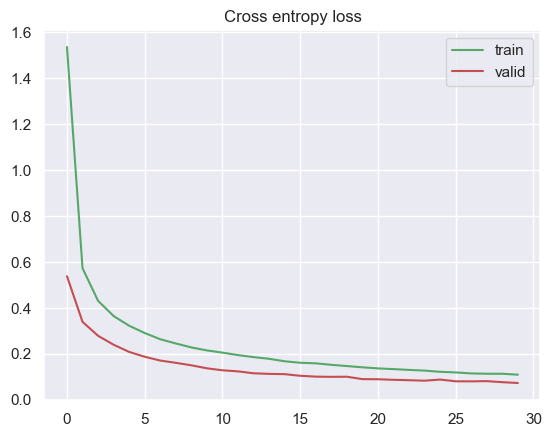

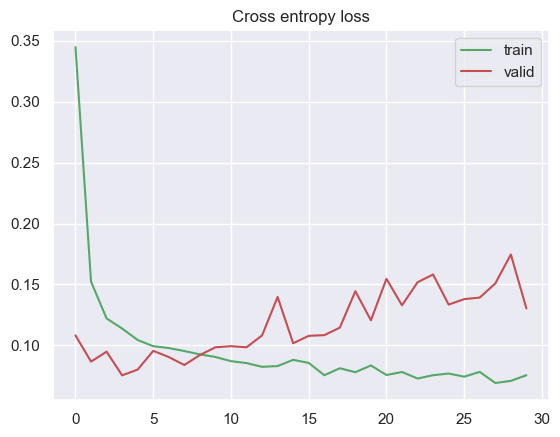

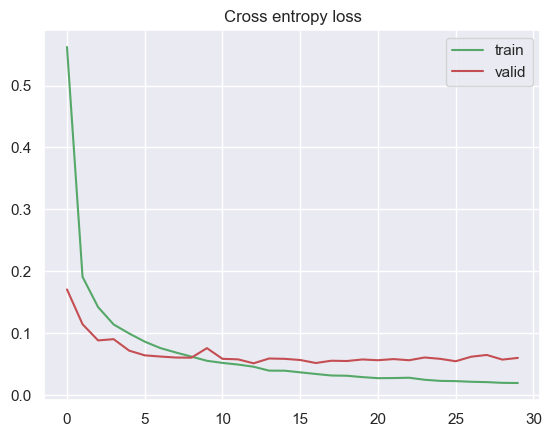

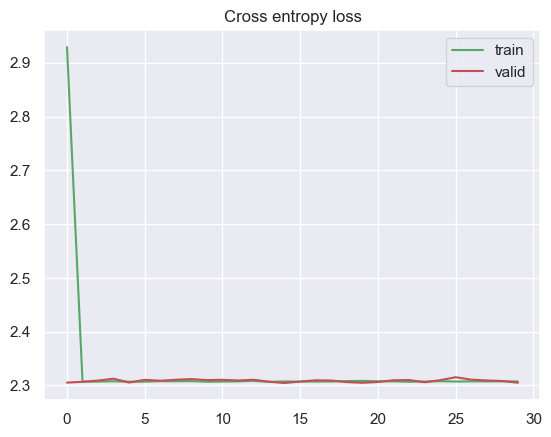

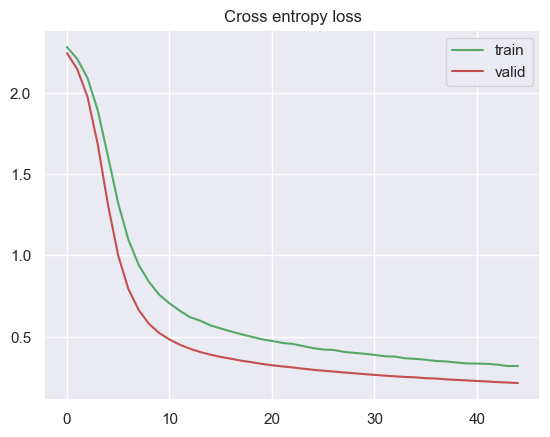

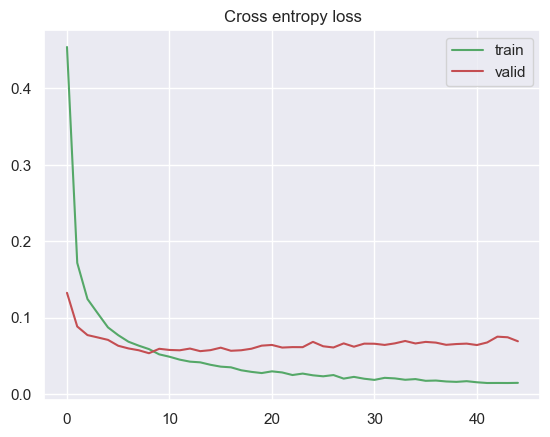

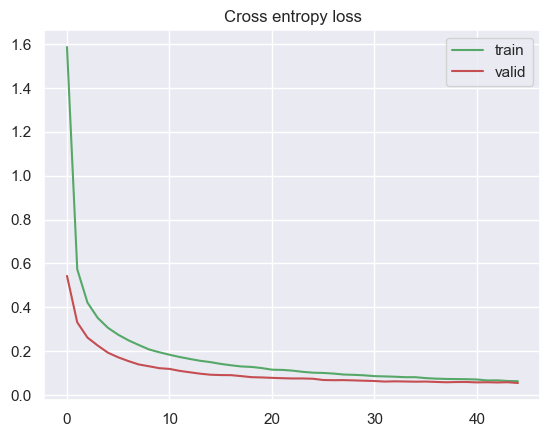

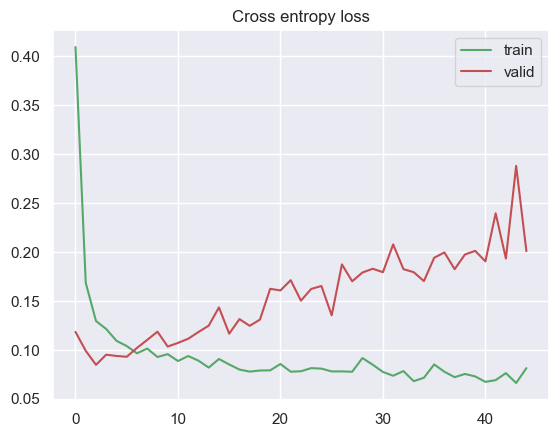

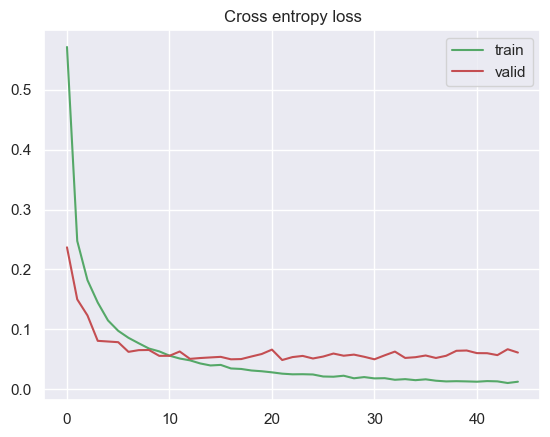

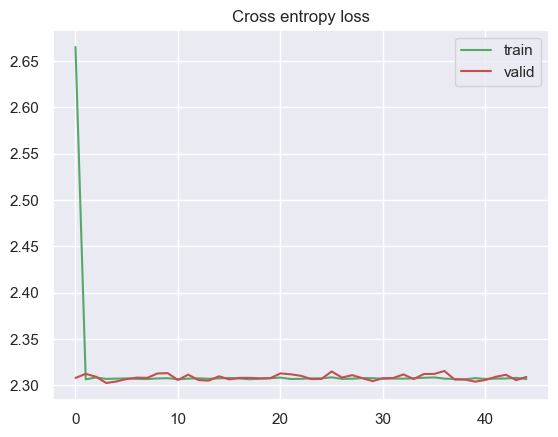

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['SGD', 'Adam'],
    'epochs': [15, 30, 45]
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Melhores desempenhos:
- SGD, 0.1 lr, 45 épocas (98.84%)
- SGD, 0.1 lr, 15 épocas (98.82%)
- adam, 0.001 lr, 45 épocas (98.66%)
- adam, 0.001 lr, 15/30 épocas (98.51%)


### Teste com inicialização

Testaremos SGD com 15 épocas, lr=0.1 com inicializações de He normal e He uniform, já que estamos utilizando a função de ativação ReLU, e essa é a inicialização geralmente recomendada. Escolhemos esses hiperparâmetros, pois há pouquíssima diferença de acurácia entre 15 e 45 épocas, portanto, iremos ficar com 15 épocas pela rapidez maior durante o treinamento.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 15, 'initialization': 'normal', 'learning_rate': 0.1, 'optimizer': 'SGD'}
Train loss: 0.121436
Valid. loss: 0.109094

              precision    recall  f1-score   support

           0     0.9722    0.9824    0.9773       853
           1     0.9920    0.9734    0.9826      1015
           2     0.9606    0.9617    0.9611       913
           3     0.9553    0.9708    0.9630       925
           4     0.9838    0.9604    0.9720       884
           5     0.9628    0.97

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017A0444CDC0>
Traceback (most recent call last):
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017A0444CDC0>
Traceback (most recent call last):
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_worke

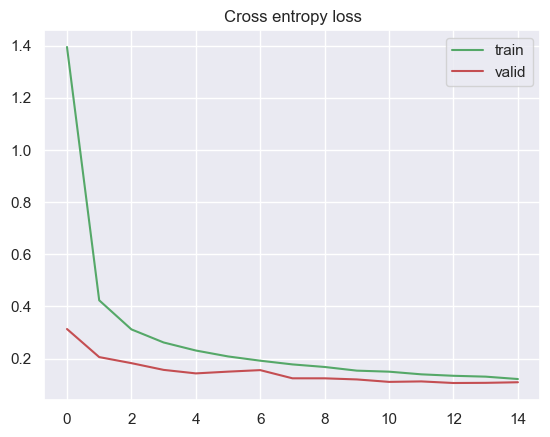

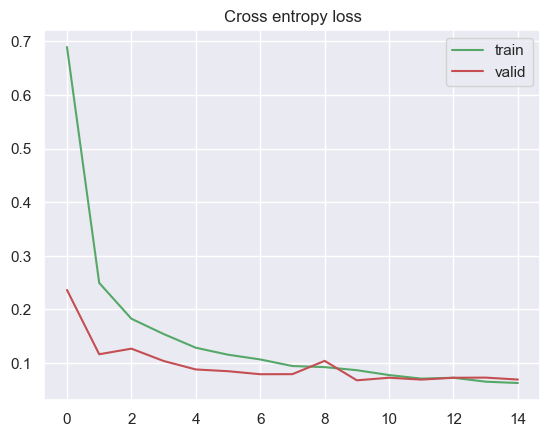

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.1],
    'optimizer': ['SGD'],
    'epochs': [15],
    'initialization': ['normal', 'uniform']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

A melhor inicialização para a escolha de hiperparâmetros usadas foi a de He uniform, com uma acurácia de 98.27%.

Testaremos ADAM com 30 épocas, lr=0.001 com inicializações de He normal e He uniform. Da mesma forma, escolhemos esses hiperparâmetros, pois há pouquíssima diferença de acurácia entre 30 e 45 épocas, portanto, iremos ficar com 30 épocas pela rapidez maior durante o treinamento e a possibilidade de ter um desempenho melhor que as 15 épocas, já que o learning rate é menor.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal', 'learning_rate': 0.001, 'optimizer': 'Adam'}
Train loss: 0.026287
Valid. loss: 0.080531

              precision    recall  f1-score   support

           0     0.9907    0.9941    0.9924       853
           1     0.9911    0.9892    0.9901      1015
           2     0.9836    0.9869    0.9852       913
           3     0.9838    0.9870    0.9854       925
           4     0.9875    0.9819    0.9847       884
           5     0.9927    0

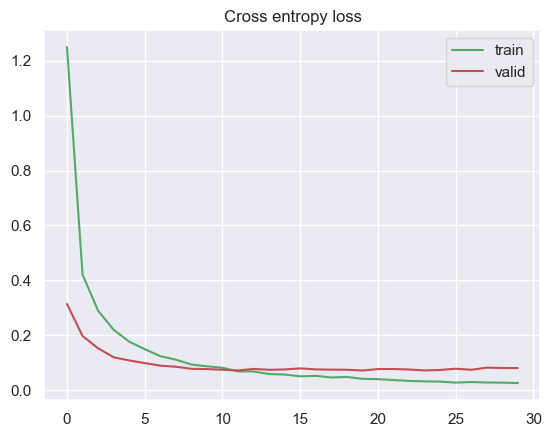

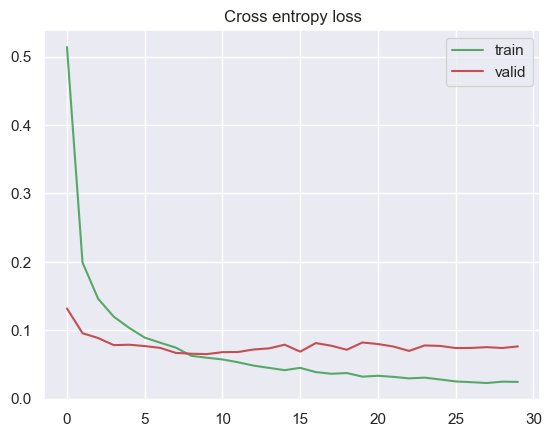

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal', 'uniform']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Após aplicar inicializações, o melhor modelo foi o
- Adam, lr = 0.001, 30 épocas, com inicialização He normal, com 98.5% de precisão.
  
A precisão diminuiu um pouco, mas isso se pagará quando estivermos trabalhando com arquiteturas maiores, já que ajudará a evitar mínimos locais, platô, e problemas como vanishing/exploding gradients.

### Testando: quantidade de canais, batch normalization, kernel size e padding

Aqui estamos testando variar os hiperparâmetros da camada convolucional: quantidade de filtros (8 e 16), kernel size (3 e 5), padding (1 e 2, de acordo com o tamanho do kernel, para manter as dimensões do tensor) e testamos também com e sem batch normalization.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 3136, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal', 'learning_rate': 0.001, 'optimizer': 'Adam'}
Train loss: 0.017364
Valid. loss: 0.067844

              precision    recall  f1-score   support

           0     0.9908    0.9977    0.9942       861
           1     0.9892    0.9921    0.9907      1016
           2     0.9794    0.9873    0.9834       868
           3     0.9924    0.9860    0.9892       930
           4     0.9888    0.9833    0.9861       899
           5     0.9768    

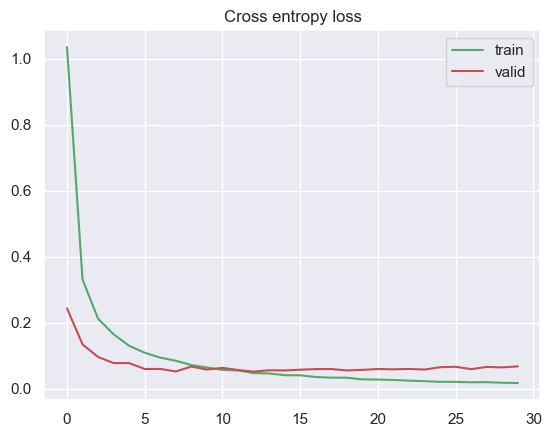

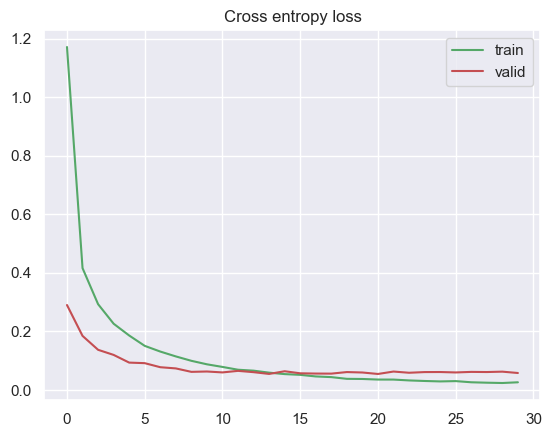

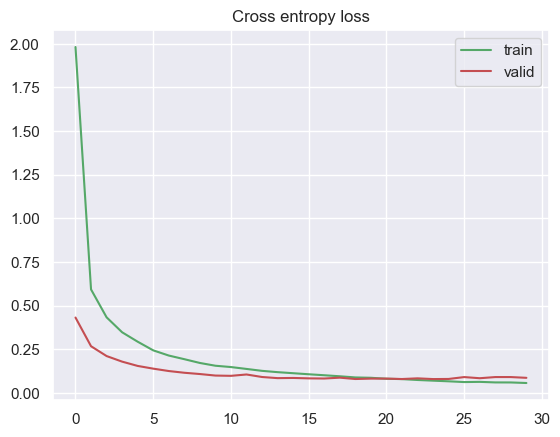

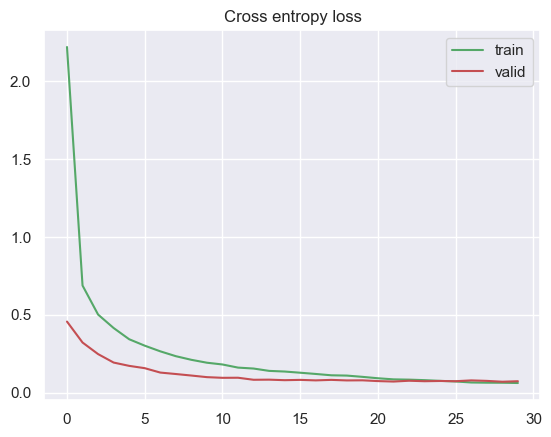

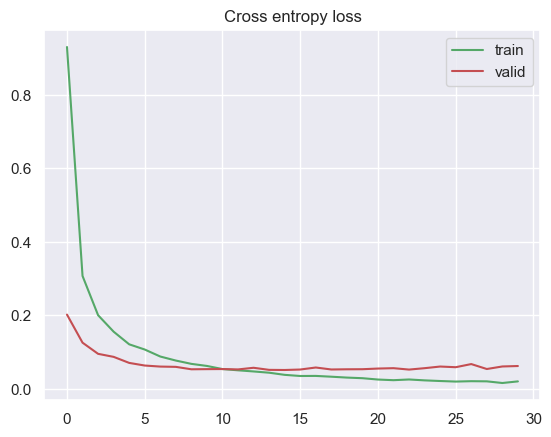

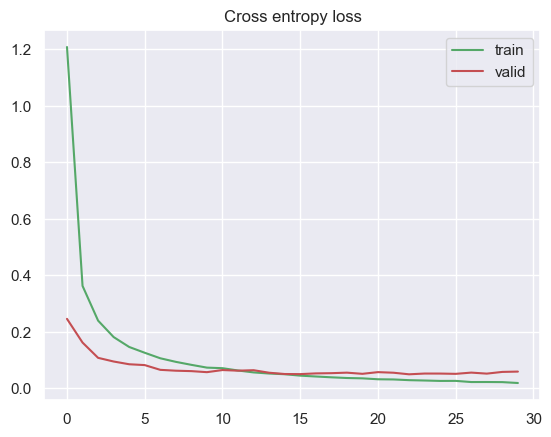

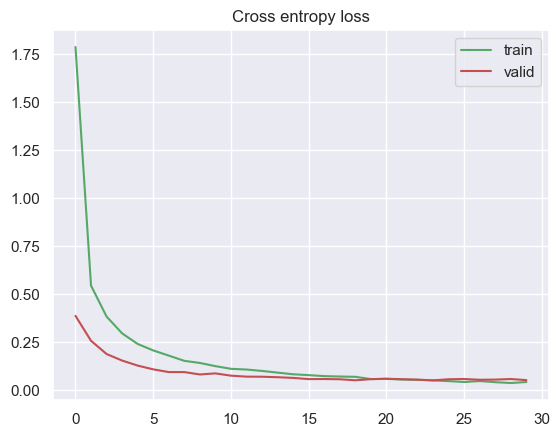

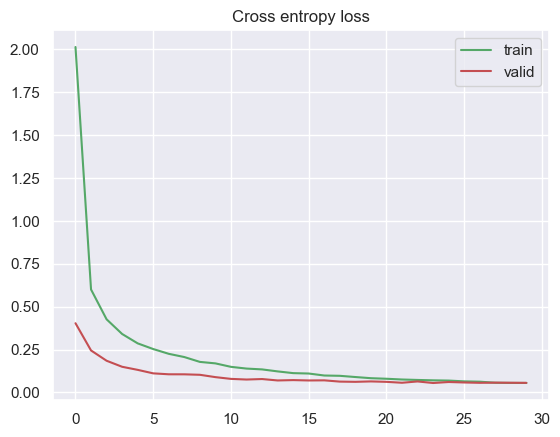

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 16*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 16*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 16*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 16*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }

    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

As melhores arquiteturas foram:
- 8 filtros, kenel 3x3, stride 1, padding 1, sem batch normalization, 98.85%
- 16 filtros, kernel 5x5, stride 1, padding 2, sem batch normalization, 98.88%

### Testes com a pooling layer e stride

Aqui testamos mudar o tamanho da stride e os parâmetros da poooling layer: todos os testes com max pooling, variando o kernel size de 3x3 com stride 3 e 2x2 com stride 2, também testando mudar o tamanho da stride na conv layer.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 392, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal', 'learning_rate': 0.001, 'optimizer': 'Adam'}
Train loss: 0.049382
Valid. loss: 0.073955

              precision    recall  f1-score   support

           0     0.9839    0.9965    0.9902       861
           1     0.9902    0.9902    0.9902      1016
           2     0.9684    0.9873    0.9778       868
           3     0.9734    0.9828    0.9781       930
           4     0.9800    0.9822    0.9811       899
           5     0.9874    0.

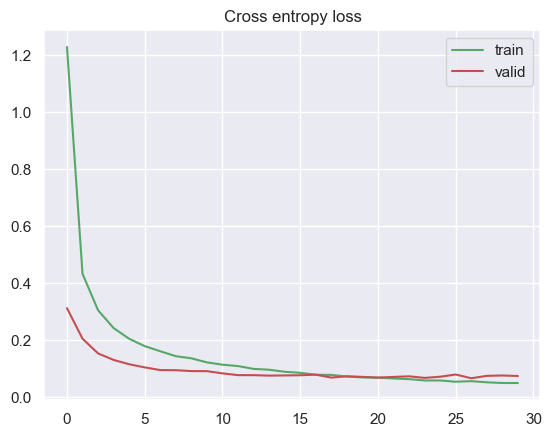

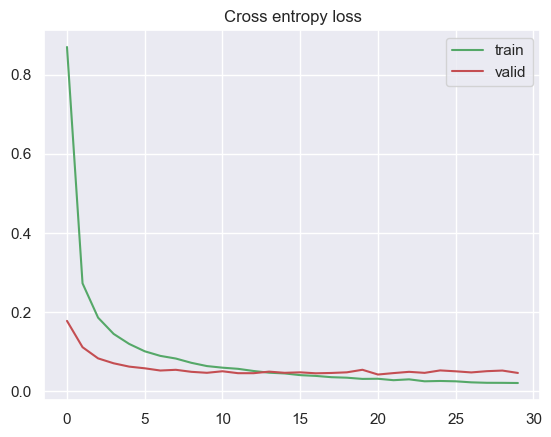

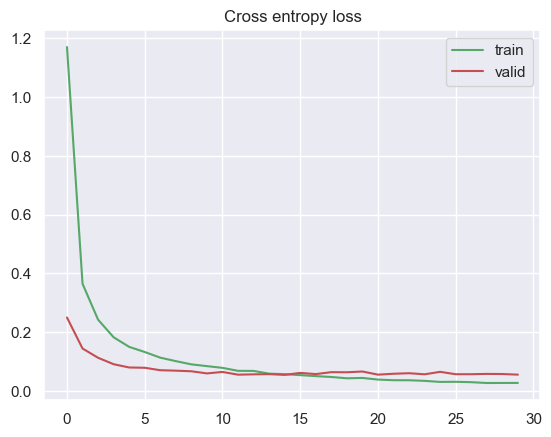

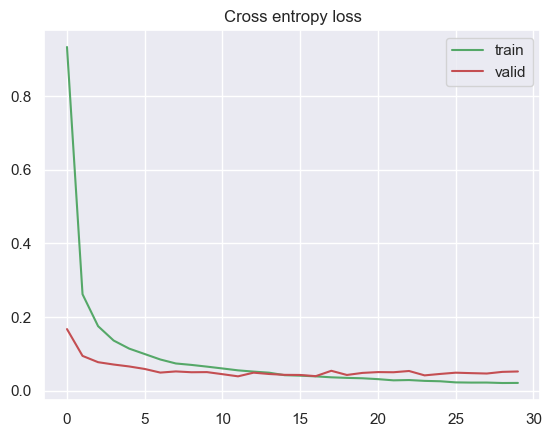

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*7*7,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 2, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 16*7*7,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 3, 'stride': 3}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*9*9,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 3, 'stride': 3}}, 'batch_norm': False}
            ],
            'mlp_input_size': 16*9*9,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }

    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Melhores resultados:
- 16 canais, kernel 5x5, stride 2, padding 2, pooling com kernel 2x2 e stride 2: 98.96%
- 16 caianis, kernel 5x5, stride 1, padding 2, pooling com kernel 3x3 e stride 3: 99.01%

### 2 camadas convolucionais

Fizemos testes inserindo uma nova camada convolucional com 32 canais de saída, kernel 5x5 e padding 2, mantendo o padrão que funcionou nos últimos testes, e testando com tamanhos diferentes no pooling layer: 3x3 e 2x2, 2x2 e 3x3, e, 2x2 e 2x2.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 3, 'stride': 3}}, 'batch_norm': False}, {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 512, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal', 'learning_rate': 0.001, 'optimizer': 'Adam'}
Train loss: 0.011742
Valid. loss: 0.059573

              precision    recall  f1-score   support

           0     0.9931    0.9977    0.9954       861
           1     0.99

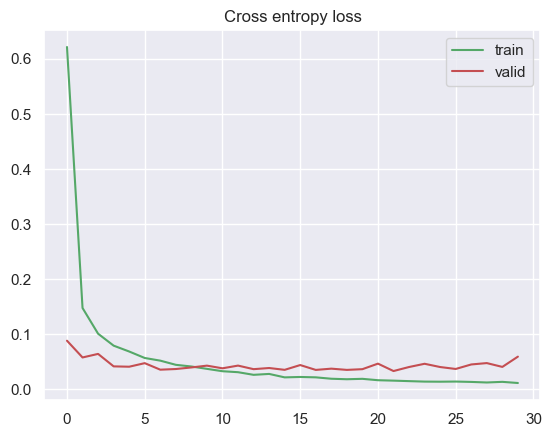

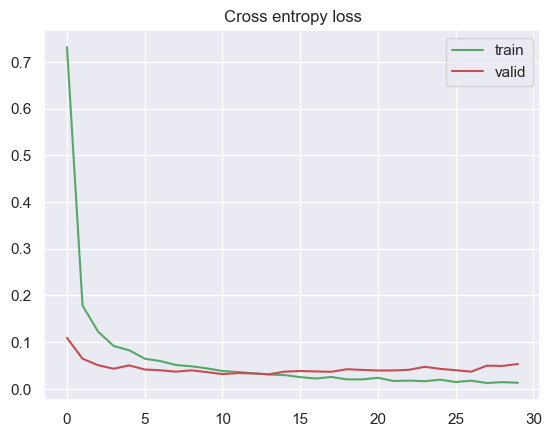

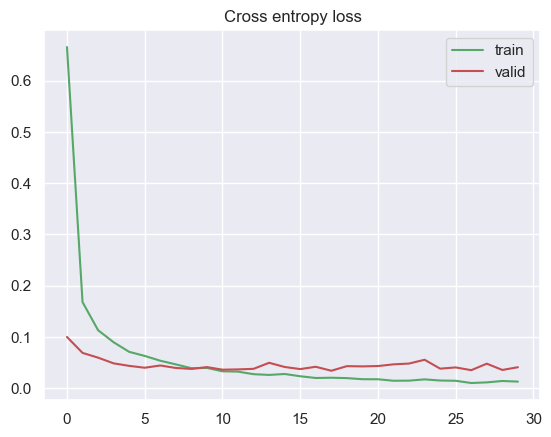

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 3, 'stride': 3}}, 'batch_norm': False},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 32*4*4,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 3, 'stride': 3}}, 'batch_norm': False}
            ],
            'mlp_input_size': 32*4*4,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 32*7*7,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Melhor arquitetura:
- 1a camada conv: 16 filtros, kernel 5x5, stride 1, padding 2, max pooling 2x2
- 2a camada conv: 32 filtros, kernel 5x5, stride 1, padding 2, max pooling 2x2

99.22% de acurácia

### 3 camadas
Testamos com uma nova camada, com 64 filtros e repetindo o padrão que funcionou nas outras camadas: kernel 5x5 com padding 2 e um teste também com a 2a camada convolucional com padding de 4, em vez de 2, para testar se evitar que a dimensão diminua muito produz algum efeito positivo.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}, {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}, {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 576, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'norma

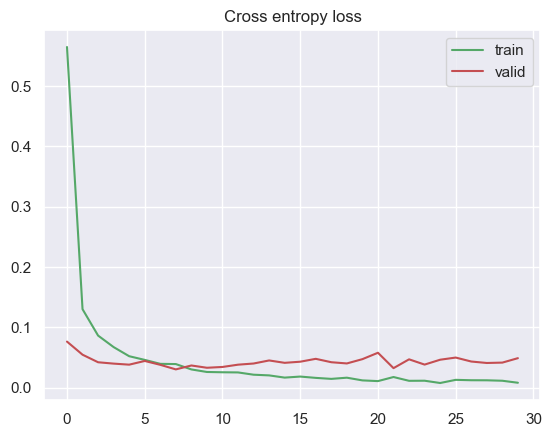

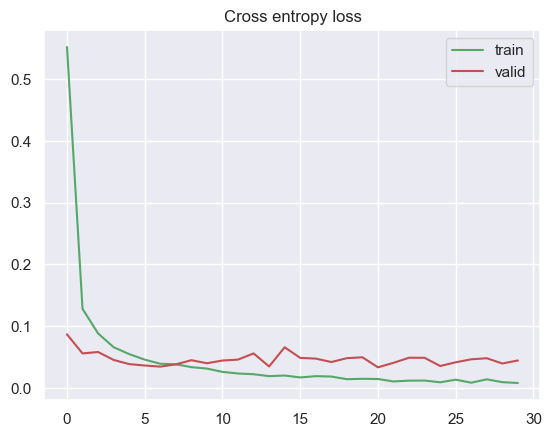

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 4, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 64*4*4,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }

    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

No final das contas, o melhor acabou sendo mantendo o padrão de padding 2, com uma precisão de 99.26%, levemente melhor que utilizando 2 camadas, (0.04% melhor), o que talvez possa ser melhorada com inserção de normalização, agora que a rede já está maior.

### Teste com batch normalization
Aplicamos batch normalization em cada uma das camadas convolucionais.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}], 'mlp_input_size': 576, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal',

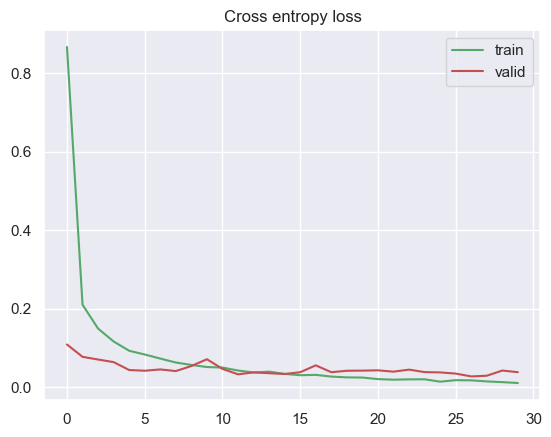

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Obtivemos uma melhoria de cerca de 0.11% (99.37%, agora) com batch normalization, sendo uma boa adição à arquitetura.

### Ajutes nas Fully Connected Layers
Tentaremos fazer mudanças na arquitetura da fully connected layer, a fim de testar possíveis melhorias.

Testamos como camadas ocultas:
- 128 e 64
- 128 e 128
- 256 e 128
- 256 e 256
- 256, 128, 64

Todos com 10 neurônios na camada de saída.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}], 'mlp_input_size': 576, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal',

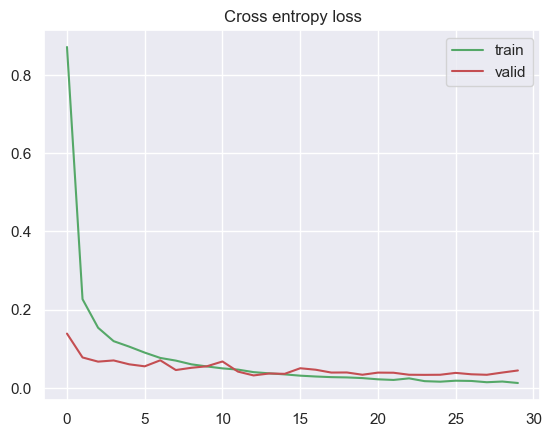

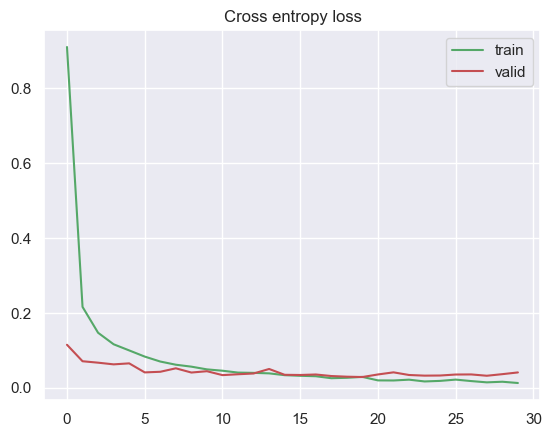

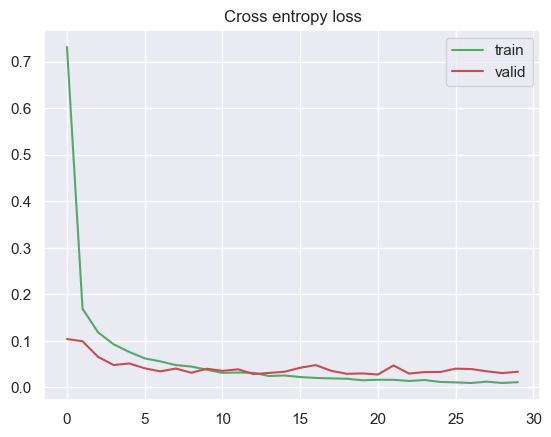

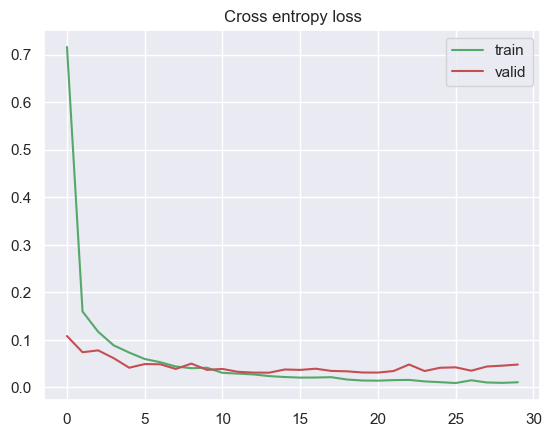

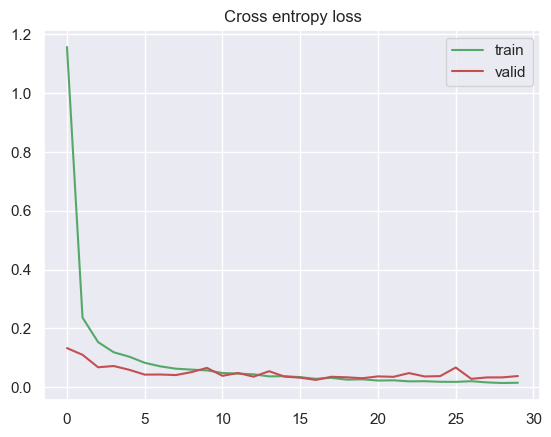

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3},
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Não obtivemos melhorias significativas, a melhor arquitetura acabou sendo com 256 e 128 neurônios nas camadas intermediárias.

### Testes finais
Mais alguns testes variando algumas coisas específicas, adicionando camadas convolucionais sem pooling layer, testando com kernel sizes diferentes, testando com arquitetura diferente da mlp, dentre outros testes.

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}, {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}], 'mlp_input_size': 576, 'mlp': [{'out_units': 256, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activ

c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train loss: 0.01358
Valid. loss: 0.03204

              precision    recall  f1-score   support

           0     0.9977    0.9942    0.9959       861
           1     0.9980    0.9951    0.9966      1016
           2     0.9897    0.9931    0.9914       868
           3     0.9978    0.9925    0.9951       930
           4     0.9955    0.9933    0.9944       899
           5     0.9901    0.9938    0.9920       807
           6     0.9968    0.9958    0.9963       947
           7     0.9899    0.9977    0.9938       885
           8     0.9907    0.9895    0.9901       858
           9     0.9893    0.9914    0.9903       929

    accuracy                         0.9937      9000
   macro avg     0.9936    0.9936    0.9936      9000
weighted avg     0.9937    0.9937    0.9937      9000

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'Ma

c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train loss: 0.009699
Valid. loss: 0.073455

              precision    recall  f1-score   support

           0     0.9874    1.0000    0.9937       861
           1     0.9667    1.0000    0.9831      1016
           2     0.9954    0.9919    0.9937       868
           3     0.9925    0.9978    0.9952       930
           4     0.9813    0.9922    0.9867       899
           5     0.9926    0.9926    0.9926       807
           6     0.9979    0.9894    0.9936       947
           7     0.9854    0.9921    0.9887       885
           8     1.0000    0.9592    0.9792       858
           9     0.9912    0.9688    0.9799       929

    accuracy                         0.9886      9000
   macro avg     0.9890    0.9884    0.9886      9000
weighted avg     0.9887    0.9886    0.9885      9000

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': '

c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train loss: 0.010608
Valid. loss: 0.029981

              precision    recall  f1-score   support

           0     0.9977    0.9988    0.9983       861
           1     0.9990    0.9931    0.9961      1016
           2     0.9931    0.9942    0.9937       868
           3     0.9968    0.9914    0.9941       930
           4     0.9933    0.9933    0.9933       899
           5     0.9877    0.9926    0.9901       807
           6     0.9958    0.9968    0.9963       947
           7     0.9866    0.9977    0.9921       885
           8     0.9907    0.9930    0.9919       858
           9     0.9935    0.9849    0.9892       929

    accuracy                         0.9936      9000
   macro avg     0.9934    0.9936    0.9935      9000
weighted avg     0.9936    0.9936    0.9936      9000

Testing with parameters: {'architecture': {'conv': [{'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': '

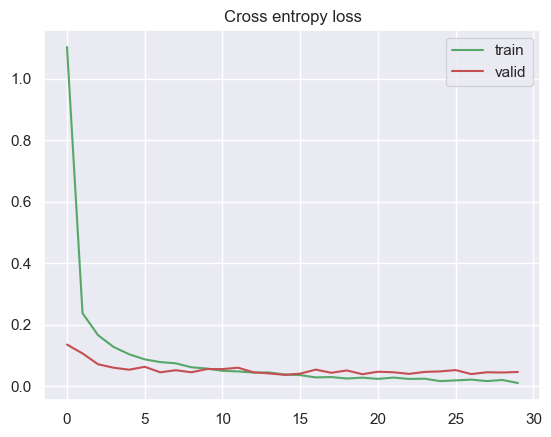

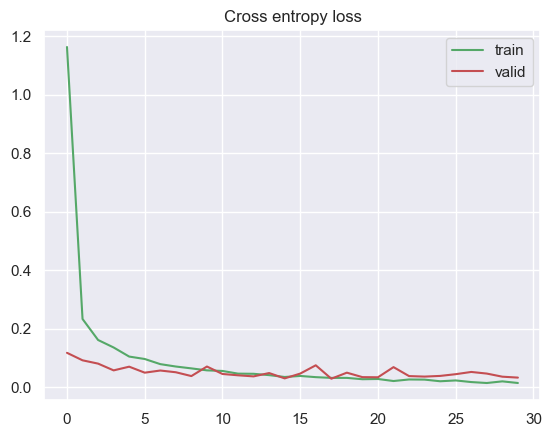

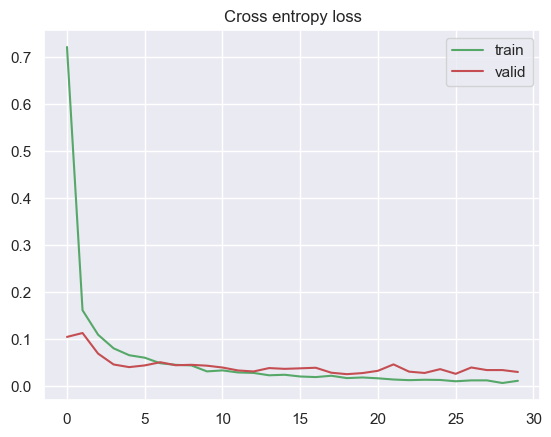

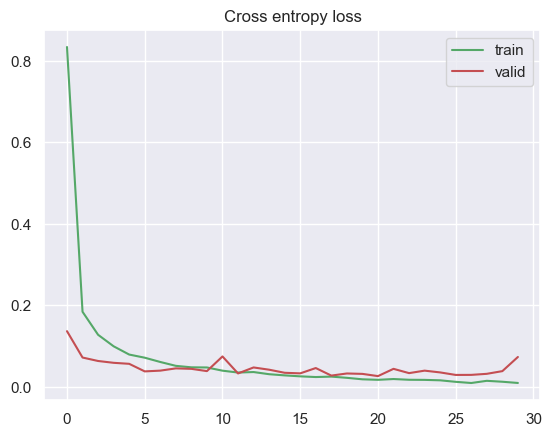

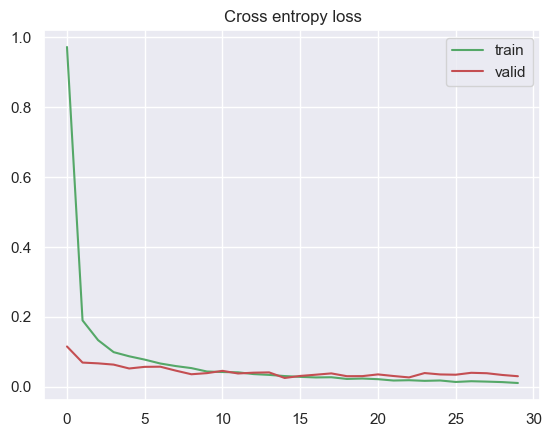

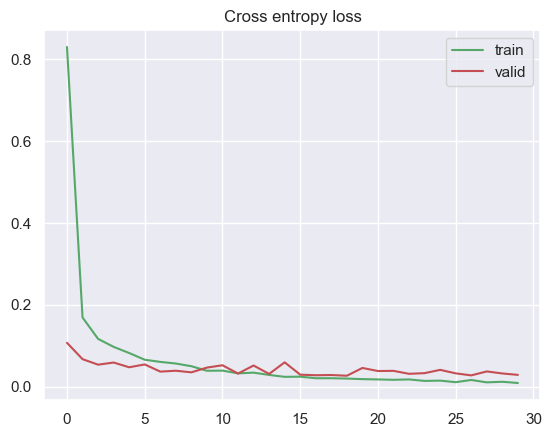

In [ ]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 90, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 90*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 90, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 90*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 90, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 90*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 64*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        },
        {
            'conv': [
                {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'batch_norm': True},
                {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
                {'out_channels': 90, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
            ],
            'mlp_input_size': 90*3*3,
            'mlp': [
                {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

No final das contas, a melhor arquitetura acabou sendo com:
- camada conv, 16 filtros, kernel 5x5, stride 1, padding 2, max pooling com kernel 2x2 e stride 2
- camada conv, 32 filtros, kernel 5x5, stride 1, padding 2, sem pooling
- camada conv, 64 filtros, kernel 5x5, stride 1, padding 2, max pooling com kernel 2x2 e stride 2
- camada conv, 90 filtros, kernel 5x5, stride 1, padding 2, max pooling com kernel 2x2 e stride 2
- flatten layer
- 256 neurônios, dropout = 30%
- 128 neurônios, dropout = 30%
- 10 neurônios, output layer.
-----------------------------------
- Otimizador: Adam
- 30 épocas
- He normal initialization
- Learning rate 1e-3


In [ ]:
model = CNN(
{
    'conv': [
        {'out_channels': 16, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'batch_norm': True},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True},
        {'out_channels': 90, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': True}
    ],
    'mlp_input_size': 90*3*3,
    'mlp': [
        {'out_units': 256, 'activation': nn.ReLU, 'dropout': 0.3},
        {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3}
    ],
    'output_units': 10
}).to(device)
model.apply(init_weights_he_normal)

loss_fn = nn.CrossEntropyLoss()
EPOCHS = 30
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 90, 7, 7]          51,930
      BatchNorm2d-13             [-1, 90, 7, 7]             180
             ReLU-14             [-1, 9

### Teste no dataset de teste

Train loss: 0.010802
Valid. loss: 0.037847

              precision    recall  f1-score   support

           0     0.9980    0.9939    0.9959       980
           1     0.9912    0.9965    0.9938      1135
           2     0.9914    1.0000    0.9957      1032
           3     0.9941    0.9941    0.9941      1010
           4     0.9859    0.9980    0.9919       982
           5     0.9888    0.9933    0.9911       892
           6     0.9948    0.9958    0.9953       958
           7     0.9951    0.9883    0.9917      1028
           8     0.9959    0.9949    0.9954       974
           9     0.9980    0.9782    0.9880      1009

    accuracy                         0.9933     10000
   macro avg     0.9933    0.9933    0.9933     10000
weighted avg     0.9933    0.9933    0.9933     10000



0.9933

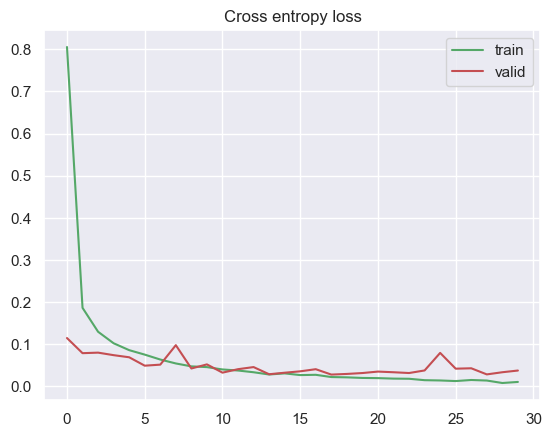

In [ ]:
train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS)
test(model, test_dl, device)

Obtivemos uma acurácia final de 99.33% no conjunto de teste.

Função para posteriormente mostrarmos algumas das imagens que erramos

In [ ]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []
    wrong_preds = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        instances = instances.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        corrects = preds == labels
        incorrect_indices = ~corrects

        total_corrects += corrects.sum().item()
        total_n += len(instances)

        all_probs.append(probabilities.cpu())
        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())

        # salvando as imagens erradas para mostrá-las posteriormente
        for idx in incorrect_indices.nonzero(as_tuple=True)[0]:
            img = instances[idx].cpu()
            pred_label = preds[idx].item()
            true_label = labels [idx].item()
            wrong_preds.append((img, pred_label, true_label))

    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    return (all_preds, all_targets, wrong_preds)

In [ ]:
all_preds, all_targets, wrong_preds = test(model, test_dl, device)

In [ ]:
len(wrong_preds)

67

Apenas 67 instâncias classificadas incorretamente, em um total de 10 mil imagens!

In [ ]:
# salvando o modelo
torch.save(model.state_dict(), 'model.pth')

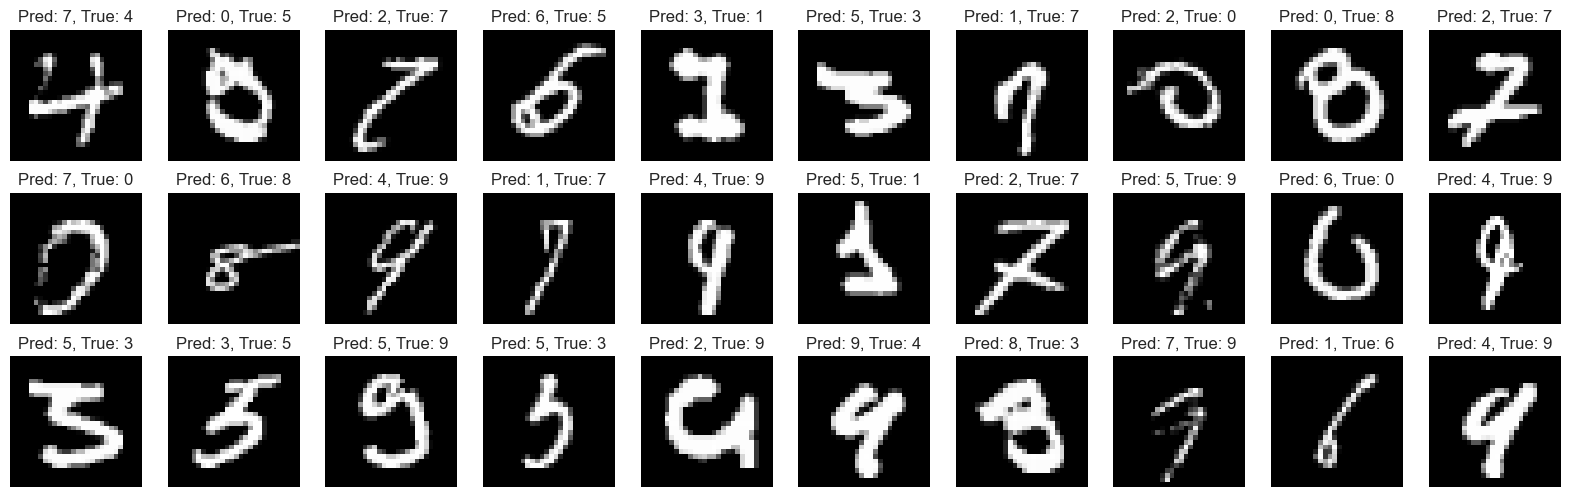

In [ ]:
def plot_wrong_predictions(wrong_preds, num_images=30):
    num_images = min(num_images, len(wrong_preds))
    num_cols = 10
    num_rows = 3

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img, pred, true = wrong_preds[i]
        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray')  # Adjust depending on your data format
        ax.set_title(f"Pred: {pred}, True: {true}")
        ax.axis('off')

    # Hide any unused axes if there are less than num_images wrong predictions
    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.show()

# Call the function to display wrong predictions
plot_wrong_predictions(wrong_preds)

Ao observar as instâncias classificadas incorretamente, podemos concluir que o modelo está com uma acurácia quase igual a de um humano normal, muitos dos erros poderiam ser cometidos por nós mesmos, podemos observar o 2o exemplo, classificado como 0 (que na verdade é um 5), o terceiro exemplo classificado como 2 (que na verdade é um 7), são erros aceitáveis. Alguns erros são mais improváveis de cometermos, como o penúltimo exemplo da primeira linha, onde ele classificou como 0 uma instância que claramente era 8.